# IMPORTS

In [13]:
import os
import random
import time
import json
import pickle
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization)
from tensorflow.keras.regularizers import l2
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# SETUP PATHS

In [14]:
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

baseline_model_path = '//kaggle/input/base-line-model/baseline_model (1).keras'
baseline_results_path = '/kaggle/input/base-line-model/results_summary.json'

In [15]:
baseline_available = os.path.exists(baseline_model_path)
print(f"\n Baseline model available: {baseline_available}")

if not baseline_available:
    print("To use the baseline model from Notebook 1:")
    print("1. Run the baseline notebook first")
    print("2. In THIS notebook, click 'Add Data' → 'Your Datasets'")
    print("3. Select the output from your baseline notebook")
    print("4. The baseline model will be available for comparison")
else:
    print(f" Baseline model found at: {baseline_model_path}")
    
    # Load baseline results if available
    if os.path.exists(baseline_results_path):
        with open(baseline_results_path, 'r') as f:
            baseline_results = json.load(f)
        print(f" Baseline test accuracy: {baseline_results['test_accuracy']*100:.2f}%")
        print(f" Baseline best val accuracy: {baseline_results['best_val_accuracy']*100:.2f}%")


 Baseline model available: True
 Baseline model found at: //kaggle/input/base-line-model/baseline_model (1).keras
 Baseline test accuracy: 77.65%
 Baseline best val accuracy: 78.36%


# DATA GENERATORS

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nDataset Summary:")
print(f"Training samples: {train.samples}")
print(f"Validation samples: {val.samples}")
print(f"Testing samples: {test.samples}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Dataset Summary:
Training samples: 4857
Validation samples: 855
Testing samples: 1311


# HELPER FUNCTIONS

In [17]:
def create_cnn_model(filters=[64, 128, 256],
                     dropout_rate=0.5,
                     l2_reg=0.001,
                     dense_units=256,
                     input_shape=(128, 128, 3),
                     num_classes=4):
    """Create CNN model for brain tumor classification"""
    model = Sequential(name='BrainTumorCNN')
    
    model.add(Conv2D(filters[0], (3, 3), activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.4))
    
    model.add(Conv2D(filters[1], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    model.add(Conv2D(filters[2], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.8))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units // 2, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [18]:
def train_and_evaluate(model, train_gen, val_gen,
                       learning_rate=0.001,
                       optimizer_type='adam',
                       epochs=50,
                       patience=10,
                       verbose=0):
    """Train model and return validation accuracy"""
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        mode='max',
        verbose=0
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=1e-6,
        verbose=0
    )
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler],
        verbose=verbose
    )
    training_time = time.time() - start_time
    
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    return history, best_val_acc, training_time, best_epoch

In [19]:
def evaluate_model(model, test_gen, class_names, model_name="Model"):
    """Evaluate model on test set"""
    print(f"EVALUATING {model_name.upper()}")
    
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")
    print(f" Test Loss: {test_loss:.4f}")
    
    print("CLASSIFICATION REPORT")
    report = classification_report(y_true, y_pred_classes,
                                   target_names=class_names,
                                   digits=4)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    print("PER-CLASS ACCURACY")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name:15s}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'predictions': y_pred_classes,
        'probabilities': y_pred_probs,
        'true_labels': y_true
    }

In [20]:
def plot_training_history(history, title="Training History"):
    """Plot training history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs_range, acc, 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_acc, 'r-s', label='Validation', linewidth=2, markersize=4)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label='Best')
    ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15)
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, loss, 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs_range, val_loss, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Model Loss', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Best Validation Accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

In [21]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Particle Swarm Optimizer

**Particle class**

In [22]:
class Particle:
    """
    Represents a single particle in PSO
    Each particle is a set of hyperparameters
    """
    def __init__(self, bounds):
        self.position = {}
        self.velocity = {}
        self.best_position = {}
        self.best_score = -np.inf
        self.bounds = bounds

        # Initialize position randomly within bounds
        for param, (low, high, param_type) in bounds.items():
            if param_type == 'continuous':
                self.position[param] = np.random.uniform(low, high)
                self.velocity[param] = np.random.uniform(-0.1, 0.1) * (high - low)
            elif param_type == 'discrete':
                # For discrete, store as continuous then round during evaluation
                self.position[param] = np.random.uniform(low, high)
                self.velocity[param] = np.random.uniform(-0.5, 0.5)

        self.best_position = self.position.copy()

    def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
        """
        Update particle velocity
        w: inertia weight
        c1: cognitive parameter
        c2: social parameter
        """
        for param in self.position.keys():
            r1 = np.random.random()
            r2 = np.random.random()

            cognitive = c1 * r1 * (self.best_position[param] - self.position[param])
            social = c2 * r2 * (global_best_position[param] - self.position[param])

            self.velocity[param] = w * self.velocity[param] + cognitive + social

    def update_position(self):
        """
        Update particle position and clip to bounds
        """
        for param, (low, high, param_type) in self.bounds.items():
            self.position[param] += self.velocity[param]
            # Clip to bounds
            self.position[param] = np.clip(self.position[param], low, high)

    def get_discrete_position(self):
        """
        Convert continuous position to discrete values where needed
        """
        discrete_pos = {}
        for param, value in self.position.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                discrete_pos[param] = int(round(value))
            else:
                discrete_pos[param] = value
        return discrete_pos

**particle optimizer**

In [23]:
class PSO_Optimizer:
    """
    Particle Swarm Optimization for hyperparameter tuning
    """
    def __init__(self, bounds, n_particles=10, n_iterations=20,
                 w=0.7, c1=1.5, c2=1.5):
        self.bounds = bounds
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.swarm = [Particle(bounds) for _ in range(n_particles)]
        self.global_best_position = None
        self.global_best_score = -np.inf

        self.history = {
            'iteration': [],
            'best_score': [],
            'mean_score': [],
            'std_score': [],
            'best_params': []
        }

    def evaluate_particle(self, particle, train_gen, val_gen, iteration, particle_id, subset_ratio=0.5):
        """
        Evaluate a particle (train model with its hyperparameters) on a subset of data for speed
        """
        params = particle.get_discrete_position()

        print(f"\n[Iteration {iteration+1}/{self.n_iterations}] [Particle {particle_id+1}/{self.n_particles}]")
        print(f"  Config: filters=({params['filter1']}, {params['filter2']}, {params['filter3']}), "
              f"dense={params['dense_units']}, lr={params['learning_rate']:.6f}")

        try:
            # Create model with particle's hyperparameters
            model = create_cnn_model(
                filters=[params['filter1'], params['filter2'], params['filter3']],
                dropout_rate=params['dropout_rate'],
                l2_reg=params['l2_reg'],
                dense_units=params['dense_units']
            )

            # Train model
            history, val_acc, train_time, best_epoch = train_and_evaluate(
                model,
                train_gen,
                val_gen,
                learning_rate=params['learning_rate'],
                optimizer_type='adam',
                epochs=10,
                patience=2,
                verbose=0
            )

            print(f"  Result: Val Acc={val_acc*100:.2f}% | Time={train_time:.1f}s | Epoch={best_epoch}")

            del model
            tf.keras.backend.clear_session()

            return val_acc

        except Exception as e:
            print(f"  Error: {str(e)}")
            return 0.0

    def optimize(self, train_gen, val_gen, baseline_score=None):
        """
        Run PSO optimization with parallel particle evaluation
        """
        print("PARTICLE SWARM OPTIMIZATION")
        print(f"Particles: {self.n_particles}")
        print(f"Iterations: {self.n_iterations}")
        print(f"Inertia (w): {self.w}, Cognitive (c1): {self.c1}, Social (c2): {self.c2}")
        if baseline_score:
            print(f"Baseline Score to Beat: {baseline_score*100:.2f}%")

        start_time = time.time()

        for iteration in range(self.n_iterations):
            print(f"\nPSO ITERATION {iteration + 1}/{self.n_iterations}")
            iteration_scores = [0.0] * self.n_particles

            def eval_particle(i, particle):
                score = self.evaluate_particle(particle, train_gen, val_gen, iteration, i)
                iteration_scores[i] = score

                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()

                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
                    improvement = ""
                    if baseline_score:
                        improvement = f" ({((self.global_best_score - baseline_score)/baseline_score*100):+.2f}% vs baseline)"
                    print(f" NEW GLOBAL BEST: {self.global_best_score*100:.2f}%{improvement}")
                return score

            # Run all particles in parallel
            with ThreadPoolExecutor(max_workers=self.n_particles) as executor:
                futures = [executor.submit(eval_particle, i, p) for i, p in enumerate(self.swarm)]
                for f in futures:
                    f.result()

            # Update velocities and positions
            for particle in self.swarm:
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position()

            # Record history
            self.history['iteration'].append(iteration + 1)
            self.history['best_score'].append(self.global_best_score)
            self.history['mean_score'].append(np.mean(iteration_scores))
            self.history['std_score'].append(np.std(iteration_scores))
            self.history['best_params'].append(self.global_best_position.copy())

            # Iteration summary
            print(f"ITERATION {iteration + 1} SUMMARY")
            print(f"  Best Score:  {self.global_best_score*100:.2f}%")
            print(f"  Mean Score:  {np.mean(iteration_scores)*100:.2f}%")
            print(f"  Std Score:   {np.std(iteration_scores)*100:.2f}%")
            print(f"  Min Score:   {np.min(iteration_scores)*100:.2f}%")
            print(f"  Max Score:   {np.max(iteration_scores)*100:.2f}%")

        total_time = time.time() - start_time
        print("\nOPTIMIZATION COMPLETE")
        print(f"Total time: {total_time/60:.2f} minutes")
        print(f"Best validation accuracy: {self.global_best_score*100:.2f}%")
        if baseline_score:
            improvement = (self.global_best_score - baseline_score) / baseline_score * 100
            print(f"Improvement over baseline: {improvement:+.2f}%")

        # Return discrete best parameters
        best_params_discrete = {}
        for param, value in self.global_best_position.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                best_params_discrete[param] = int(round(value))
            else:
                best_params_discrete[param] = value

        return best_params_discrete, self.global_best_score

    def plot_convergence(self, baseline_score=None, save_path=None):
        """
        Plot PSO convergence
        """
        fig = plt.figure(figsize=(14, 10))

        # Plot 1: Best and Mean scores
        plt.subplot(2, 1, 1)
        plt.plot(self.history['iteration'],
                [s*100 for s in self.history['best_score']],
                'b-o', linewidth=2, markersize=6, label='Best Score')
        plt.plot(self.history['iteration'],
                [s*100 for s in self.history['mean_score']],
                'r--s', linewidth=2, markersize=5, label='Mean Score')
        
        if baseline_score:
            plt.axhline(y=baseline_score*100, color='orange', linestyle='--', 
                       linewidth=2, label=f'Baseline ({baseline_score*100:.2f}%)')

        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
        plt.title('PSO Convergence History', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)

        # Plot 2: Score diversity (std)
        plt.subplot(2, 1, 2)
        plt.plot(self.history['iteration'],
                [s*100 for s in self.history['std_score']],
                'g-^', linewidth=2, markersize=6)
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Standard Deviation (%)', fontsize=12, fontweight='bold')
        plt.title('Swarm Diversity Over Time', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

LOAD BASELINE MODEL 

In [24]:
baseline_score = None

if baseline_available:
    print("LOADING BASELINE MODEL FOR COMPARISON")
    try:
        baseline_model = load_model(baseline_model_path)
        print(" Baseline model loaded successfully")
        
        val_loss, val_acc = baseline_model.evaluate(val, verbose=0)
        baseline_score = val_acc
    except Exception as e:
        print(f"Could not load baseline model: {e}")
        baseline_score = None

LOADING BASELINE MODEL FOR COMPARISON


I0000 00:00:1766156052.459770      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


 Baseline model loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766156057.989729     166 service.cc:152] XLA service 0x7f2198003470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766156057.989765     166 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766156058.174994     166 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766156060.307499     166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


RUN PSO

In [25]:
pso_bounds = {
    'learning_rate': (0.0001, 0.01, 'continuous'),
    'dropout_rate': (0.2, 0.7, 'continuous'),
    'l2_reg': (0.0001, 0.01, 'continuous'),
    'filter1': (32, 128, 'discrete'),
    'filter2': (64, 256, 'discrete'),
    'filter3': (128, 512, 'discrete'),
    'dense_units': (128, 512, 'discrete')
}

print("\nPSO Search Space:")
for param, (low, high, ptype) in pso_bounds.items():
    if ptype == 'continuous':
        print(f"  {param:15s}: [{low:.6f}, {high:.6f}] ({ptype})")
    else:
        print(f"  {param:15s}: [{low:7d}, {high:7d}] ({ptype})")

pso_optimizer = PSO_Optimizer(
    bounds=pso_bounds,
    n_particles=3,      # Number of particles
    n_iterations=8,     # Number of iterations
    w=0.7,              # Inertia weight
    c1=1.5,             # Cognitive parameter
    c2=1.5              # Social parameter
)

# Run optimization
best_pso_params, best_pso_score = pso_optimizer.optimize(train, val, baseline_score=baseline_score)


PSO Search Space:
  learning_rate  : [0.000100, 0.010000] (continuous)
  dropout_rate   : [0.200000, 0.700000] (continuous)
  l2_reg         : [0.000100, 0.010000] (continuous)
  filter1        : [     32,     128] (discrete)
  filter2        : [     64,     256] (discrete)
  filter3        : [    128,     512] (discrete)
  dense_units    : [    128,     512] (discrete)
PARTICLE SWARM OPTIMIZATION
Particles: 3
Iterations: 8
Inertia (w): 0.7, Cognitive (c1): 1.5, Social (c2): 1.5
Baseline Score to Beat: 78.36%

PSO ITERATION 1/8

[Iteration 1/8] [Particle 1/3]
  Config: filters=(72, 99, 170), dense=447, lr=0.008458

[Iteration 1/8] [Particle 2/3]
  Config: filters=(115, 119, 179), dense=378, lr=0.005393

[Iteration 1/8] [Particle 3/3]
  Config: filters=(46, 241, 217), dense=155, lr=0.006735


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-19 14:54:59.366268: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  Result: Val Acc=25.50% | Time=161.8s | Epoch=1
 NEW GLOBAL BEST: 25.50% (-67.46% vs baseline)
  Result: Val Acc=44.68% | Time=163.4s | Epoch=1
 NEW GLOBAL BEST: 44.68% (-42.99% vs baseline)
  Result: Val Acc=56.73% | Time=239.0s | Epoch=4
 NEW GLOBAL BEST: 56.73% (-27.61% vs baseline)
ITERATION 1 SUMMARY
  Best Score:  56.73%
  Mean Score:  42.30%
  Std Score:   12.86%
  Min Score:   25.50%
  Max Score:   56.73%

PSO ITERATION 2/8

[Iteration 2/8] [Particle 1/3]
  Config: filters=(72, 99, 170), dense=447, lr=0.007837

[Iteration 2/8] [Particle 2/3]
  Config: filters=(71, 93, 170), dense=474, lr=0.008124

[Iteration 2/8] [Particle 3/3]
  Config: filters=(68, 215, 174), dense=251, lr=0.007547
  Error: Exception encountered when calling Conv2D.call().

Dimensions must be equal, but are 68 and 71 for '{{node BrainTumorCNN_1/conv2d_1/Add}} = AddV2[T=DT_FLOAT](BrainTumorCNN_1/conv2d_1/convolution, BrainTumorCNN_1/conv2d_1/Reshape)' with input shapes: [?,128,128,68], [1,1,1,71].

Arguments 

2025-12-19 15:01:18.149426: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  Result: Val Acc=38.01% | Time=156.6s | Epoch=1
  Result: Val Acc=55.67% | Time=239.4s | Epoch=4
  Result: Val Acc=54.62% | Time=272.0s | Epoch=5
ITERATION 3 SUMMARY
  Best Score:  56.73%
  Mean Score:  49.43%
  Std Score:   8.09%
  Min Score:   38.01%
  Max Score:   55.67%

PSO ITERATION 4/8

[Iteration 4/8] [Particle 1/3]
  Config: filters=(72, 100, 170), dense=446, lr=0.009305

[Iteration 4/8] [Particle 2/3]
  Config: filters=(67, 118, 166), dense=395, lr=0.008990

[Iteration 4/8] [Particle 3/3]
  Config: filters=(44, 145, 192), dense=353, lr=0.007436


2025-12-19 15:05:24.015205: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 15:05:36.274340: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  Result: Val Acc=42.22% | Time=147.6s | Epoch=1
  Result: Val Acc=52.05% | Time=215.4s | Epoch=3
  Result: Val Acc=56.49% | Time=241.2s | Epoch=4
ITERATION 4 SUMMARY
  Best Score:  56.73%
  Mean Score:  50.25%
  Std Score:   5.96%
  Min Score:   42.22%
  Max Score:   56.49%

PSO ITERATION 5/8

[Iteration 5/8] [Particle 1/3]
  Config: filters=(72, 100, 170), dense=447, lr=0.008986

[Iteration 5/8] [Particle 2/3]
  Config: filters=(69, 113, 169), dense=403, lr=0.007718

[Iteration 5/8] [Particle 3/3]
  Config: filters=(41, 79, 187), dense=427, lr=0.007705
  Error: Exception encountered when calling Conv2D.call().

Dimensions must be equal, but are 72 and 69 for '{{node BrainTumorCNN_1/conv2d_1/Add}} = AddV2[T=DT_FLOAT](BrainTumorCNN_1/conv2d_1/convolution, BrainTumorCNN_1/conv2d_1/Reshape)' with input shapes: [?,128,128,72], [1,1,1,69].

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  Error: Exception encountered when calling Conv2D.

2025-12-19 15:22:45.178440: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 15:23:32.228969: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  Result: Val Acc=36.61% | Time=148.8s | Epoch=1
  Result: Val Acc=65.15% | Time=304.7s | Epoch=6
  Result: Val Acc=62.34% | Time=306.6s | Epoch=6
ITERATION 8 SUMMARY
  Best Score:  80.12%
  Mean Score:  54.70%
  Std Score:   12.84%
  Min Score:   36.61%
  Max Score:   65.15%

OPTIMIZATION COMPLETE
Total time: 33.05 minutes
Best validation accuracy: 80.12%
Improvement over baseline: +2.24%


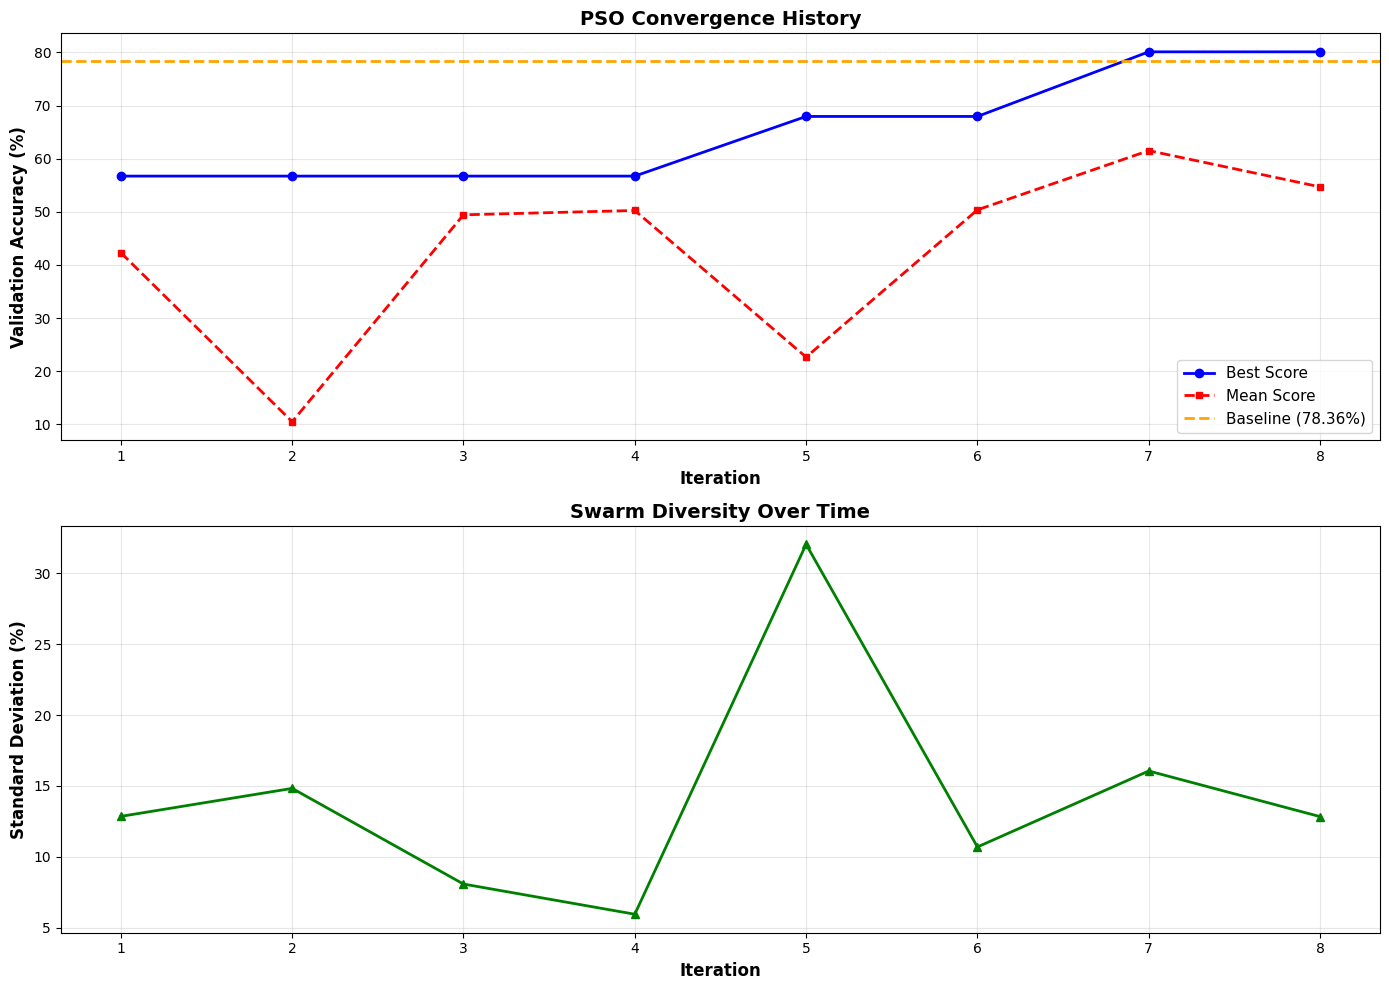

In [26]:
# Plot convergence
pso_optimizer.plot_convergence(baseline_score=baseline_score, 
                              save_path='/kaggle/working/pso_convergence.png')

TRAIN FINAL MODEL

TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 39)   │         1,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 39)   │           156 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 39)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 39)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 184)    │       106,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 184)    │           736 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 184)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 184)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 47104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 420)            │    19,784,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 420)            │         1,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 210)            │        88,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 210)            │           840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 210)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,006,810 (76.32 MB)

 Trainable params: 20,004,976 (76.31 MB)

 Non-trainable params: 1,834 (7.16 KB)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.5433 - loss: 13.4644 - val_accuracy: 0.2994 - val_loss: 8.6924 - learning_rate: 0.0075
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.6423 - loss: 4.9272 - val_accuracy: 0.4222 - val_loss: 4.2714 - learning_rate: 0.0075
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.6728 - loss: 2.5935 - val_accuracy: 0.3977 - val_loss: 2.9601 - learning_rate: 0.0075
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 178ms/step - accuracy: 0.6983 - loss: 2.0260 - val_accuracy: 0.7275 - val_loss: 2.1862 - learning_rate: 0.0075
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.6775 - loss: 2.1238 - val_accuracy: 0.4234 - val_loss: 2.8224 - learning_rate: 0.0075
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 171ms/step - accuracy: 0.6900 - loss: 2.0305 - val_accuracy: 0.6959 - val_loss: 1.9594 - learning_rate: 0.0075
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.

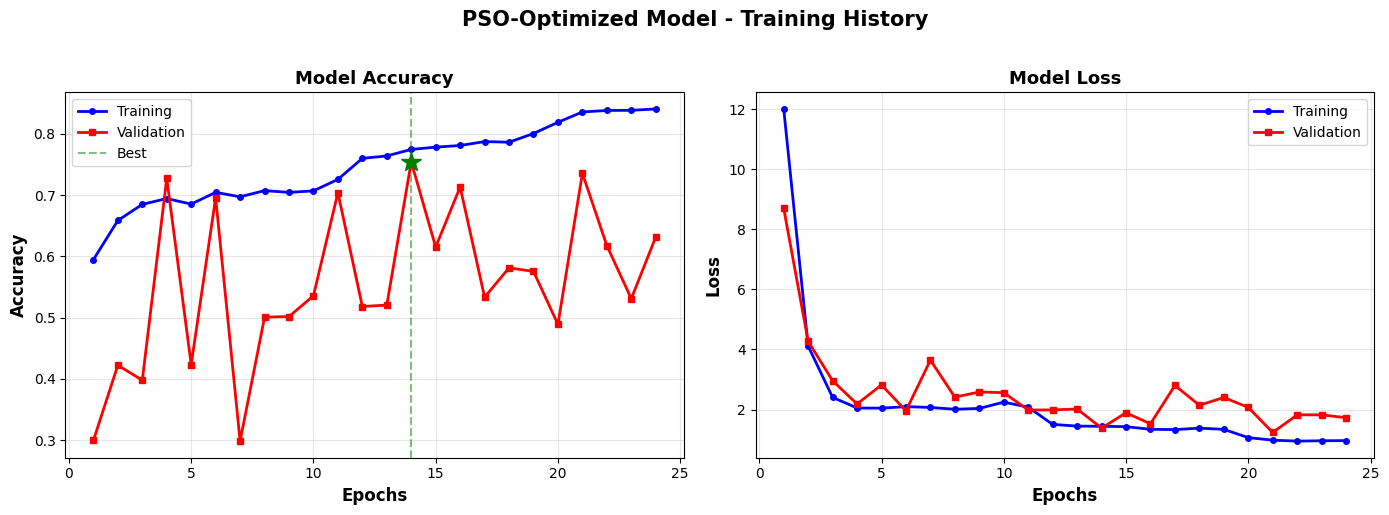


 Best Validation Accuracy: 75.44% at epoch 14


In [33]:
print("TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS")

pso_model = create_cnn_model(
    filters=[best_pso_params['filter1'], best_pso_params['filter2'], best_pso_params['filter3']],
    dropout_rate=best_pso_params['dropout_rate'],
    l2_reg=best_pso_params['l2_reg'],
    dense_units=best_pso_params['dense_units']
)

pso_model.summary()

pso_history, pso_val_acc, pso_time, pso_epoch = train_and_evaluate(
    pso_model,
    train,
    val,
    learning_rate=best_pso_params['learning_rate'],
    optimizer_type='adam',
    epochs=50,
    patience=10,
    verbose=1
)

print(f"\n Final validation accuracy: {pso_val_acc*100:.2f}% at epoch {pso_epoch}")
if baseline_score:
    improvement = (pso_val_acc - baseline_score) / baseline_score * 100
    print(f" Improvement over baseline: {improvement:+.2f}%")

plot_training_history(pso_history, "PSO-Optimized Model - Training History")

EVALUATE ON TEST SET

EVALUATING PSO-OPTIMIZED MODEL

 Test Accuracy: 74.60%
 Test Loss: 1.3694
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.9875    0.5267    0.6870       300
  meningioma     0.4931    0.6961    0.5772       306
     notumor     0.8304    0.9432    0.8832       405
   pituitary     0.8687    0.7500    0.8050       300

    accuracy                         0.7460      1311
   macro avg     0.7949    0.7290    0.7381      1311
weighted avg     0.7964    0.7460    0.7490      1311

PER-CLASS ACCURACY
  glioma         : 52.67% (158/300)
  meningioma     : 69.61% (213/306)
  notumor        : 94.32% (382/405)
  pituitary      : 75.00% (225/300)


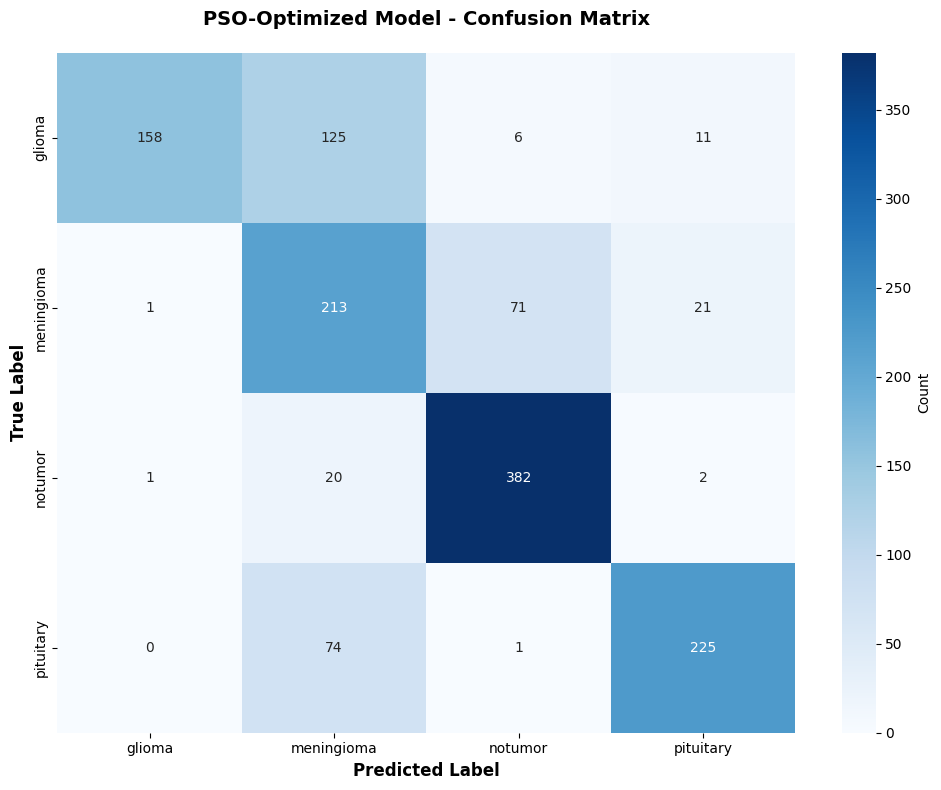

In [34]:
class_names = list(train.class_indices.keys())
pso_results = evaluate_model(pso_model, test, class_names, "PSO-Optimized Model")
plot_confusion_matrix(pso_results['confusion_matrix'], 
                     class_names, "PSO-Optimized Model - Confusion Matrix")

# SAVE MODELS AND RESULTS

In [35]:
pso_model.save('/kaggle/working/pso_optimized_model.keras')
print(" PSO-optimized model saved as: /kaggle/working/pso_optimized_model.keras")

# Save best parameters
params_to_save = {}
for key, value in best_pso_params.items():
    if isinstance(value, (np.integer, np.floating)):
        params_to_save[key] = float(value)
    else:
        params_to_save[key] = value

with open('/kaggle/working/pso_best_parameters.json', 'w') as f:
    json.dump(params_to_save, f, indent=2)
print(" Best parameters saved as: /kaggle/working/pso_best_parameters.json")

# Save optimization history
pso_history_dict = {
    'optimization': {
        'iterations': pso_optimizer.history['iteration'],
        'best_scores': [float(s) for s in pso_optimizer.history['best_score']],
        'mean_scores': [float(s) for s in pso_optimizer.history['mean_score']],
        'std_scores': [float(s) for s in pso_optimizer.history['std_score']]
    },
    'training': {
        'accuracy': [float(x) for x in pso_history.history['accuracy']],
        'val_accuracy': [float(x) for x in pso_history.history['val_accuracy']],
        'loss': [float(x) for x in pso_history.history['loss']],
        'val_loss': [float(x) for x in pso_history.history['val_loss']]
    }
}

with open('/kaggle/working/pso_optimization_history.json', 'w') as f:
    json.dump(pso_history_dict, f, indent=2)
print(" Optimization history saved as: /kaggle/working/pso_optimization_history.json")

# Save history as pickle (includes all best_params history)
with open('/kaggle/working/pso_history.pkl', 'wb') as f:
    pickle.dump(pso_optimizer.history, f)
print(" Full PSO history saved as: /kaggle/working/pso_history.pkl")

# Save results summary
pso_results_summary = {
    'optimization': {
        'algorithm': 'Particle Swarm Optimization',
        'n_particles': pso_optimizer.n_particles,
        'n_iterations': pso_optimizer.n_iterations,
        'inertia_weight': pso_optimizer.w,
        'cognitive_param': pso_optimizer.c1,
        'social_param': pso_optimizer.c2,
        'best_val_accuracy_during_search': float(best_pso_score),
        'best_parameters': params_to_save
    },
    'final_model': {
        'test_accuracy': float(pso_results['accuracy']),
        'test_loss': float(pso_results['loss']),
        'val_accuracy': float(pso_val_acc),
        'best_epoch': int(pso_epoch),
        'training_time_seconds': float(pso_time)
    },
    'class_names': class_names
}

if baseline_available and baseline_score:
    pso_results_summary['baseline_comparison'] = {
        'baseline_test_accuracy': float(baseline_test_results['accuracy']),
        'baseline_val_accuracy': float(baseline_score),
        'test_accuracy_improvement': float(pso_results['accuracy'] - baseline_test_results['accuracy']),
        'test_accuracy_improvement_percent': float((pso_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100),
        'val_accuracy_improvement': float(pso_val_acc - baseline_score),
        'val_accuracy_improvement_percent': float((pso_val_acc - baseline_score) / baseline_score * 100)
    }

with open('/kaggle/working/pso_results_summary.json', 'w') as f:
    json.dump(pso_results_summary, f, indent=2)
print(" Results summary saved as: /kaggle/working/pso_results_summary.json")

if baseline_available and baseline_score:
    comparison.to_csv('/kaggle/working/model_comparison.csv', index=False)
    print(" Model comparison saved as: /kaggle/working/model_comparison.csv")

 PSO-optimized model saved as: /kaggle/working/pso_optimized_model.keras
 Best parameters saved as: /kaggle/working/pso_best_parameters.json
 Optimization history saved as: /kaggle/working/pso_optimization_history.json
 Full PSO history saved as: /kaggle/working/pso_history.pkl
 Results summary saved as: /kaggle/working/pso_results_summary.json
 Model comparison saved as: /kaggle/working/model_comparison.csv


**FINAL SUMMARY**

In [36]:
print(f"\nBest Hyperparameters Found:")
for param, value in best_pso_params.items():
    if isinstance(value, float):
        print(f"  {param:15s}: {value:.6f}")
    else:
        print(f"  {param:15s}: {value}")

print(f"\nPSO Statistics:")
print(f"  Particles:       {pso_optimizer.n_particles}")
print(f"  Iterations:      {pso_optimizer.n_iterations}")
print(f"  Total Evals:     {pso_optimizer.n_particles * pso_optimizer.n_iterations}")
print(f"  Inertia (w):     {pso_optimizer.w}")
print(f"  Cognitive (c1):  {pso_optimizer.c1}")
print(f"  Social (c2):     {pso_optimizer.c2}")

print(f"\nSaved Files:")
print(f"  - pso_optimized_model.keras")
print(f"  - pso_best_parameters.json")
print(f"  - pso_optimization_history.json")
print(f"  - pso_history.pkl")
print(f"  - pso_results_summary.json")
print(f"  - pso_convergence.png")
if baseline_available and baseline_score:
    print(f"  - model_comparison.csv")
    print(f"  - confusion_matrix_comparison.png")
    print(f"  - per_class_comparison.png")


Best Hyperparameters Found:
  learning_rate  : 0.007534
  dropout_rate   : 0.336252
  l2_reg         : 0.000598
  filter1        : 39
  filter2        : 64
  filter3        : 184
  dense_units    : 420

PSO Statistics:
  Particles:       3
  Iterations:      8
  Total Evals:     24
  Inertia (w):     0.7
  Cognitive (c1):  1.5
  Social (c2):     1.5

Saved Files:
  - pso_optimized_model.keras
  - pso_best_parameters.json
  - pso_optimization_history.json
  - pso_history.pkl
  - pso_results_summary.json
  - pso_convergence.png
  - model_comparison.csv
  - confusion_matrix_comparison.png
  - per_class_comparison.png
